### Денисов Владислав Львович, группа 3824М1ПМвм
### Лабораторная работа №1 «Метод обратного распространения ошибки»

In [1]:
# Загрузка библиотек
import os
import gzip
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Параметры датасета и обучения
IMG_H, IMG_W = 28, 28
INPUT_SIZE = IMG_H * IMG_W
NUM_CLASSES = 10

DEFAULT_HIDDEN = 300
DEFAULT_BATCH = 64
DEFAULT_LR = 0.1
DEFAULT_EPOCHS = 20

RANDOM_SEED = 33414
np.random.seed(RANDOM_SEED)

# Пути к набору данных
DATA_DIR = "C:/Users/vladr/Documents/Learning/DeepLearning/DataSets/MNIST"
FILES = {
    "train_images": "train-images-idx3-ubyte.gz",
    "train_labels": "train-labels-idx1-ubyte.gz",
    "test_images":  "t10k-images-idx3-ubyte.gz",
    "test_labels":  "t10k-labels-idx1-ubyte.gz",
}

Загружаем данные из локальной директории...
Train images: (60000, 784)
Train labels: (60000,)
Test images: (10000, 784)
Test labels: (10000,)
Первые 12 изображений из тренировочного набора:


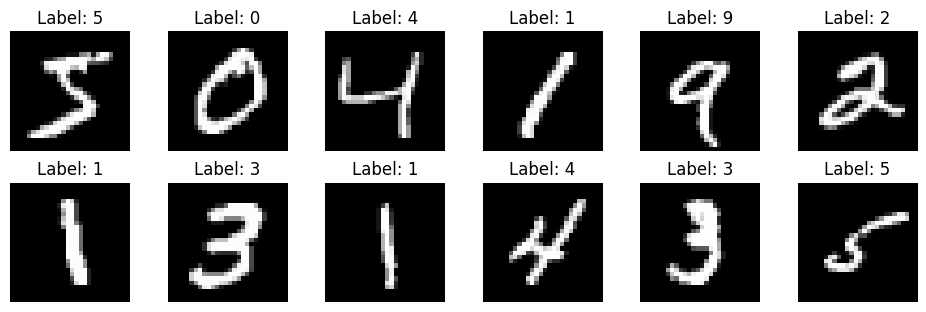

Первые 6 меток (обычные): [5 0 4 1 9 2]
Первые 6 меток (one-hot):
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


In [3]:
# Загружает изображения MNIST из .gz файла и возвращает numpy массив (N, 784)
def load_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, IMG_H * IMG_W).astype(np.float32) / 255.0
    return data

# Загружает метки MNIST из .gz файла и возвращает numpy массив (N,)
def load_labels(filename):
    with gzip.open(filename, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)
    return labels

# Преобразует метки в one-hot вектор
# Пример: метка 3 будет представлена как [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
def to_one_hot(y, num_classes=NUM_CLASSES):
    return np.eye(num_classes, dtype=np.float32)[y]

print("Загружаем данные из локальной директории...")
train_images = load_images(os.path.join(DATA_DIR, FILES["train_images"]))
train_labels = load_labels(os.path.join(DATA_DIR, FILES["train_labels"]))
test_images  = load_images(os.path.join(DATA_DIR, FILES["test_images"]))
test_labels  = load_labels(os.path.join(DATA_DIR, FILES["test_labels"]))

# Проверка корректности загрузки
print("Train images:", train_images.shape)
print("Train labels:", train_labels.shape)
print("Test images:", test_images.shape)
print("Test labels:", test_labels.shape)

y_train_oh = to_one_hot(train_labels)
y_test_oh = to_one_hot(test_labels)

# Визуализация данных
def show_samples(images, labels, count_for_show=6):
    cols = 6
    rows = int(np.ceil(count_for_show / cols))
    plt.figure(figsize=(cols*1.6, rows*1.6))
    for i in range(count_for_show):
        plt.subplot(rows, cols, i+1)
        plt.imshow(images[i].reshape((IMG_H, IMG_W)), cmap='gray', vmin=0, vmax=1)
        plt.title("Label: " + str(labels[i]), fontsize=12)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

count_images_for_show = 12
print(f"Первые {count_images_for_show} изображений из тренировочного набора:")
show_samples(train_images, train_labels, count_for_show=count_images_for_show)

print("Первые 6 меток (обычные):", train_labels[:6])
print("Первые 6 меток (one-hot):")
print(y_train_oh[:6])


In [4]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.1):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        self._initialize_parameters()

    # Инициализация весов и смещений (Kaiming initialization - компенсирует отсечение ReLU)
    def _initialize_parameters(self):
        # Синаптические веса (входные сигналы от других нейронов)
        self.W1 = np.random.randn(self.input_size, self.hidden_size) * np.sqrt(2. / self.input_size)
        self.W2 = np.random.randn(self.hidden_size, self.output_size) * np.sqrt(2. / self.hidden_size)
        # Воздействие внешней среды (смещения) - сводобный член
        self.b1 = np.zeros((1, self.hidden_size))
        self.b2 = np.zeros((1, self.output_size))

    # ReLU = max(0, x)
    def _relu(self, Z):
        return np.maximum(0, Z)

    # Производная ReLU
    def _relu_derivative(self, Z):
        return (Z > 0).astype(float)

    # Softmax = exp(x) / sum(exp(x))
    def _softmax(self, Z):
        Z_shift = Z - np.max(Z, axis=1, keepdims=True)  # чтобы не было переполнения exp
        exp_scores = np.exp(Z_shift)
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Кросс-энтропия между предсказанными вероятностями и истинными значениями
    def _cross_entropy_loss(self, y_true, y_pred):
        eps = 1e-12
        y_pred_clipped = np.clip(y_pred, eps, 1 - eps)  # предотвращение log(0)
        return -np.mean(np.sum(y_true * np.log(y_pred_clipped), axis=1))
    
    # Обратное распространение ошибки - вычисление градиентов
    def _backward(self, X, y_true, y_pred):
        m = X.shape[0]                              # размер батча

        dZ2 = y_pred - y_true                       # ошибка на выходе
        dW2 = (self.A1.T @ dZ2) / m                 # градиент по весам второго слоя
        db2 = np.mean(dZ2, axis=0, keepdims=True)   # градиент по смещению второго слоя

        dA1 = dZ2 @ self.W2.T                       # ошибка на скрытом слое
        dZ1 = dA1 * self._relu_derivative(self.Z1)  # применение производной ReLU
        dW1 = (X.T @ dZ1) / m                       # градиент по весам первого слоя
        db1 = np.mean(dZ1, axis=0, keepdims=True)   # градиент по смещению первого слоя

        # Сохраним градиенты для обновления
        self.grads = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}

    # Обновление параметров с помощью градиентного спуска
    def _update_parameters(self):
        self.W1 -= self.learning_rate * self.grads['dW1']
        self.b1 -= self.learning_rate * self.grads['db1']
        self.W2 -= self.learning_rate * self.grads['dW2']
        self.b2 -= self.learning_rate * self.grads['db2']

    # Прямое распространение сигнала через сеть
    # Возвращает вероятности классов (softmax)
    def forward(self, X):
        self.Z1 = X @ self.W1 + self.b1           # линейная комбинация для входного слоя
        self.A1 = self._relu(self.Z1)             # активация ReLU для скрытого слоя
        self.Z2 = self.A1 @ self.W2 + self.b2     # линейная комбинация для скрытого слоя
        self.A2 = self._softmax(self.Z2)          # активация softmax для выходного слоя
        return self.A2

    # Вычисление функции потерь (кросс-энтропия)
    def compute_loss(self, y_true, y_pred):
        return self._cross_entropy_loss(y_true, y_pred)

    # Вычисление точности
    def accuracy(self, y_true_labels, y_pred_probs):
        preds = np.argmax(y_pred_probs, axis=1)
        return np.mean(preds == y_true_labels)

    def summary(self):
        print("Конфигурация нейронной сети:")
        print(f"  Входных нейронов:  {self.input_size}")
        print(f"  Скрытых нейронов: {self.hidden_size}")
        print(f"  Выходных нейронов: {self.output_size}")
        print(f"  Скорость обучения:  {self.learning_rate}")

    def train(self, X, y, epochs=10, batch_size=64, verbose=True):
        n_samples = X.shape[0]

        # История обучения
        history = {
            'train_loss': [],
            'train_accuracy': [],
            'epoch_time': []
        }

        for epoch in range(1, epochs + 1):
            start_time = time.time()

            # Перемешиваем данные, чтобы избежать застревания в локальных минимумах
            idx = np.random.permutation(n_samples)
            X_shuffled = X[idx]
            y_shuffled = y[idx]

            # Обработка всех батчей
            for i in range(0, n_samples, batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]

                y_pred = self.forward(X_batch)
                self._backward(X_batch, y_batch, y_pred)
                self._update_parameters()

            # Оценка качества на тренировочной выборке
            y_pred_train = self.forward(X)
            train_loss = self.compute_loss(y, y_pred_train)
            train_acc = self.accuracy(np.argmax(y, axis=1), y_pred_train)

            history['train_loss'].append(train_loss)
            history['train_accuracy'].append(train_acc)

            epoch_time = time.time() - start_time
            history['epoch_time'].append(epoch_time)

            if verbose:
                print(f"Эпоха {epoch:02d}: "
                      f"Train loss={train_loss:.4f}, acc={train_acc*100:.2f}% | "
                      f"Время: {epoch_time:.2f} c")

        return history

In [5]:
# Создадим экземпляр нейросети
net = NeuralNetwork(
    input_size=INPUT_SIZE,
    hidden_size=DEFAULT_HIDDEN,
    output_size=NUM_CLASSES,
    learning_rate=DEFAULT_LR
)

net.summary()

print(f"\nНачинаем обучение (эпох: {DEFAULT_EPOCHS}, размер пачки: {DEFAULT_BATCH})...")
history = net.train(
    X=train_images,
    y=y_train_oh,
    epochs=DEFAULT_EPOCHS,
    batch_size=DEFAULT_BATCH,
    verbose=True
)
total_time = sum(history['epoch_time'])
print(f"Обучение завершено {total_time:.2f} секунд.")

print("\nЗапускаем классификацию на тестовых данных...")
y_pred_test = net.forward(test_images)

test_acc = net.accuracy(test_labels, y_pred_test)
print(f"\nТочность классификации на тестовой выборке: {test_acc*100:.2f}%")

Конфигурация нейронной сети:
  Входных нейронов:  784
  Скрытых нейронов: 300
  Выходных нейронов: 10
  Скорость обучения:  0.1

Начинаем обучение (эпох: 20, размер пачки: 64)...
Эпоха 01: Train loss=0.2168, acc=93.98% | Время: 4.01 c
Эпоха 02: Train loss=0.1470, acc=95.89% | Время: 4.02 c
Эпоха 03: Train loss=0.1149, acc=96.81% | Время: 4.53 c
Эпоха 04: Train loss=0.0916, acc=97.49% | Время: 4.42 c
Эпоха 05: Train loss=0.0786, acc=97.91% | Время: 4.68 c
Эпоха 06: Train loss=0.0672, acc=98.23% | Время: 4.45 c
Эпоха 07: Train loss=0.0565, acc=98.59% | Время: 4.55 c
Эпоха 08: Train loss=0.0529, acc=98.62% | Время: 4.43 c
Эпоха 09: Train loss=0.0450, acc=98.88% | Время: 4.13 c
Эпоха 10: Train loss=0.0419, acc=98.93% | Время: 4.43 c
Эпоха 11: Train loss=0.0362, acc=99.14% | Время: 4.12 c
Эпоха 12: Train loss=0.0330, acc=99.24% | Время: 4.14 c
Эпоха 13: Train loss=0.0292, acc=99.38% | Время: 4.07 c
Эпоха 14: Train loss=0.0265, acc=99.47% | Время: 4.07 c
Эпоха 15: Train loss=0.0239, acc=99.5

Истинный класс: 7
Топ-5:
  1. Класс 7: 0.9999
  2. Класс 3: 0.0001
  3. Класс 9: 0.0000
  4. Класс 2: 0.0000
  5. Класс 8: 0.0000


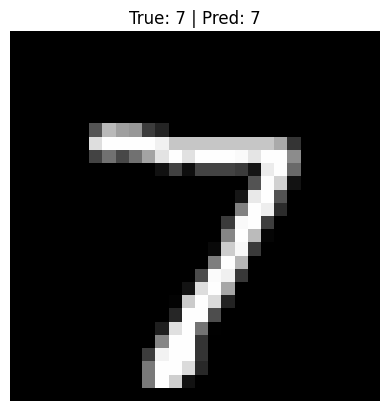

Истинный класс: 2
Топ-5:
  1. Класс 2: 0.9998
  2. Класс 3: 0.0001
  3. Класс 1: 0.0001
  4. Класс 8: 0.0000
  5. Класс 5: 0.0000


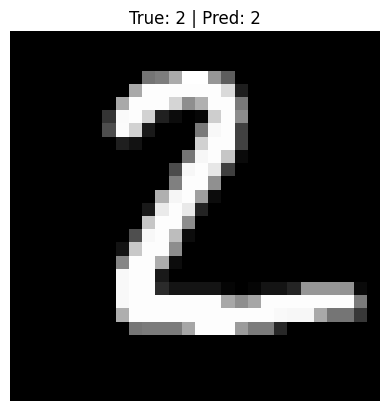

Истинный класс: 1
Топ-5:
  1. Класс 1: 0.9986
  2. Класс 7: 0.0005
  3. Класс 8: 0.0004
  4. Класс 2: 0.0003
  5. Класс 4: 0.0001


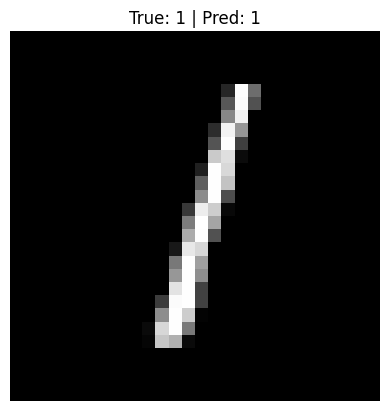

In [6]:
num_samples = 3
top_k = 5

true_labels = np.argmax(y_test_oh[:num_samples], axis=1)

for i in range(num_samples):
    probs = y_pred_test[i]
    top_indices = np.argsort(probs)[::-1][:top_k]
    top_probs = probs[top_indices]

    print(f"Истинный класс: {true_labels[i]}")
    print("Топ-5:")
    for rank, (cls, p) in enumerate(zip(top_indices, top_probs), 1):
        print(f"  {rank}. Класс {cls}: {p:.4f}")

    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {true_labels[i]} | Pred: {np.argmax(probs)}")
    plt.axis('off')
    plt.show()